<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

### Imports

In [ ]:
!pip install rioxarray
!pip install torchmetrics


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 16, 17]])
#X = np.array([[1, 4, 7, 1], [2, 1, 8, 11], [3, 6, 1, 12]])
#mask = iso == 1
#X = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
print(X)
print(X.transpose())
print(np.rot90(X))


[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 16 17]]
[[ 1  5  9 13]
 [ 2  6 10 14]
 [ 3  7 11 16]
 [ 4  8 12 17]]
[[ 4  8 12 17]
 [ 3  7 11 16]
 [ 2  6 10 14]
 [ 1  5  9 13]]


### Dunn Score/No Breakpoint

(1281, 2042)
Dunn Index: 0.29697074680018204
Dunn Index: 0.31234353467574455
Dunn Index: 0.2200004267880201
Dunn Index: 0.2003409221286743
Dunn Index: 0.15777692395719103
Dunn Index: 0.18013546971724256
Dunn Index: 0.16701238797201026
Dunn Index: 0.1442188040825953
Dunn Index: 0.1327295580739909
Dunn Index: 0.151839641403046
Dunn Index: 0.16760388352176722
Dunn Index: 0.1315133230975077
Dunn Index: 0.14502531274147146
Dunn Index: 0.12721858347852907
Dunn Index: 0.14476926805453733


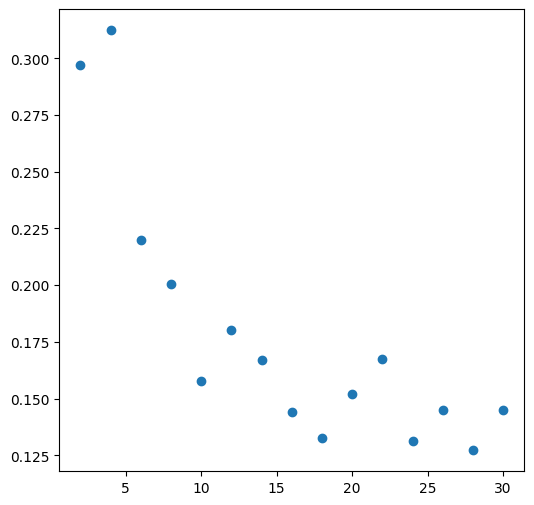

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchmetrics.clustering import DunnIndex
import numpy as np
import pandas as pd
import rioxarray as rx
import os

dunn_index = DunnIndex(p=2)


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()
  X = torch.tensor(X.astype(float))

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  cluster_labels = torch.tensor(cluster_labels.astype(float))
  score = dunn_index(X, cluster_labels)
  test_scores.append(score)

  print(f"Dunn Index: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Dunn Scores/One Breakpoint

Optimal breakpoint 1: 10.222222222222221


/tmp/ipython-input-3305133069.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


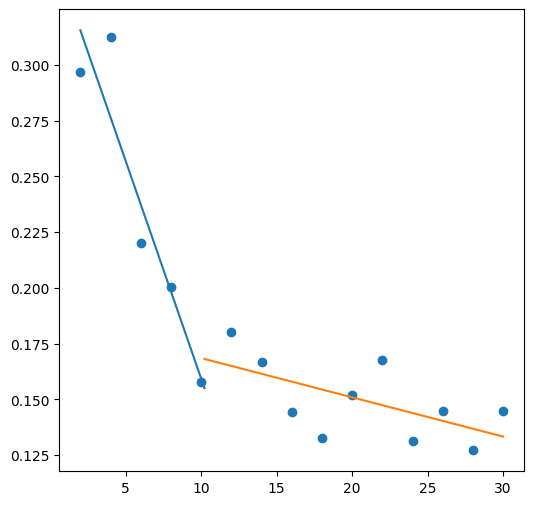

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Silhouette Score/No Breakpoint

(1281, 2042)
Silhouette score: 0.21976770817049426
Silhouette score: 0.21354694985132047
Silhouette score: 0.16121200214392184
Silhouette score: 0.16532466438765722
Silhouette score: 0.1469203445004423
Silhouette score: 0.14458892584442665
Silhouette score: 0.13504321928308075
Silhouette score: 0.12671725024383887
Silhouette score: 0.1257663921045904
Silhouette score: 0.11809453778159919
Silhouette score: 0.13444763838974055
Silhouette score: 0.11526039532884413
Silhouette score: 0.11749316530449021
Silhouette score: 0.11877916658892383
Silhouette score: 0.12095772490291412


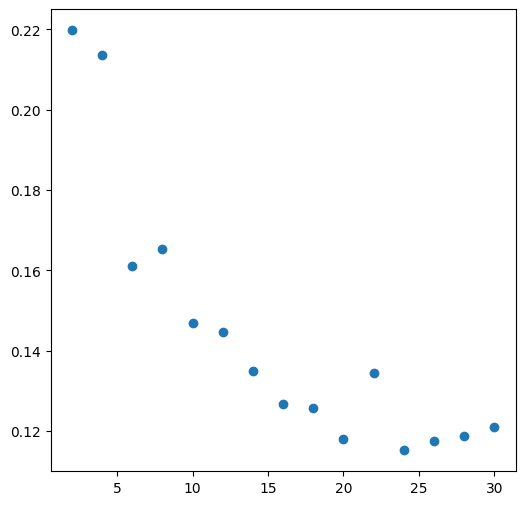

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os

isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)


test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

  print(f"Silhouette score: {avg_score}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Silhouette Score/One Breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-3164484002.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


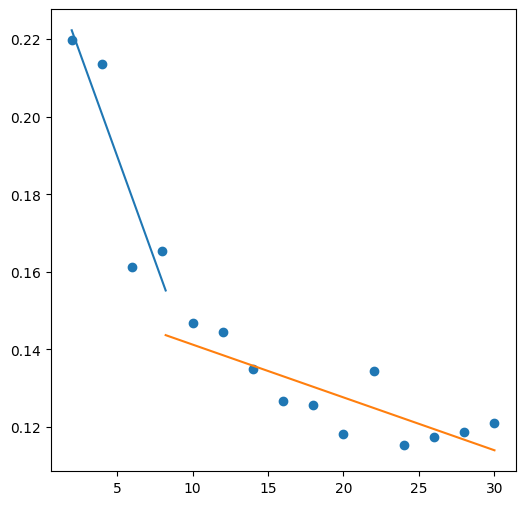

In [ ]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Davies-Bouldin Score/No Breakpoint

(1281, 2042)
Davies Bouldin Index: 1.6446426492483763
Davies Bouldin Index: 1.4380084486704776
Davies Bouldin Index: 1.6296086845541327
Davies Bouldin Index: 1.5504116252014617
Davies Bouldin Index: 1.7048773476649597
Davies Bouldin Index: 1.742543800592248
Davies Bouldin Index: 1.743913738425386
Davies Bouldin Index: 1.741963883212906
Davies Bouldin Index: 1.7272458207949986
Davies Bouldin Index: 1.7243466356548047
Davies Bouldin Index: 1.669304421878911
Davies Bouldin Index: 1.7167569713864144
Davies Bouldin Index: 1.7146247310851157
Davies Bouldin Index: 1.7055199867375521
Davies Bouldin Index: 1.6858992340481114


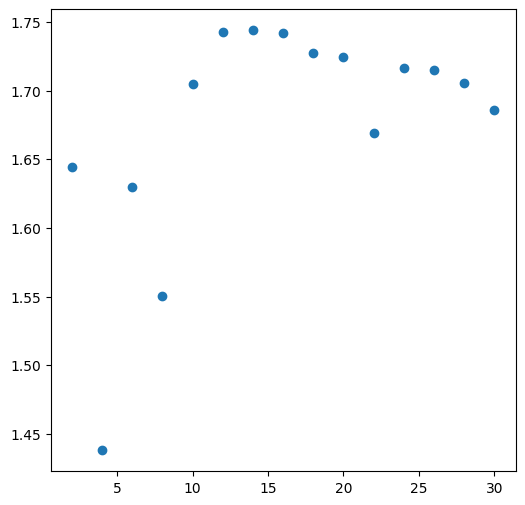

In [ ]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  score = davies_bouldin_score(X, cluster_labels)
  test_scores.append(score)

  print(f"Davies Bouldin Index: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Davies-Bouldin Score/One Breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-597286820.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


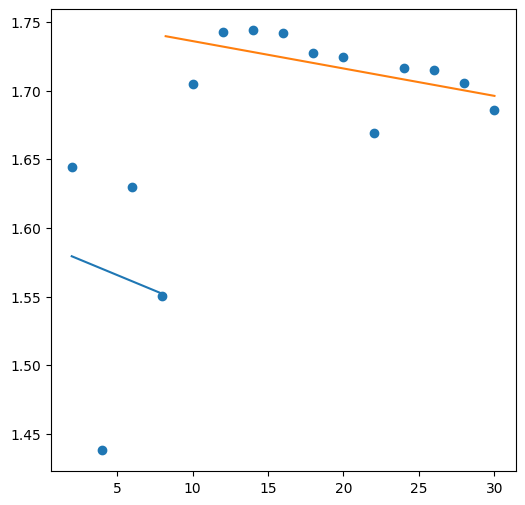

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Purity Score/No Breakpoint

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
253,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
254,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Purity Score: 0.7678692753610691
Purity Score: 0.7507544151534732
Purity Score: 0.5837716507447444
Purity Score: 0.5566669110033429
Purity Score: 0.513306595919906
Purity Score: 0.4693081309291426
Purity Score: 0.40593171426406716
Purity Score: 0.37407349688285946
Purity Score: 0.361008671077457
Purity Score: 0.31621067077809323
Purity Score: 0.3278230279720323
Purity Score: 0.28951740221245836
Purity Score: 0.27813665154859146
Purity Score: 0.2634924663200371
Purity Score: 0.256992084107665


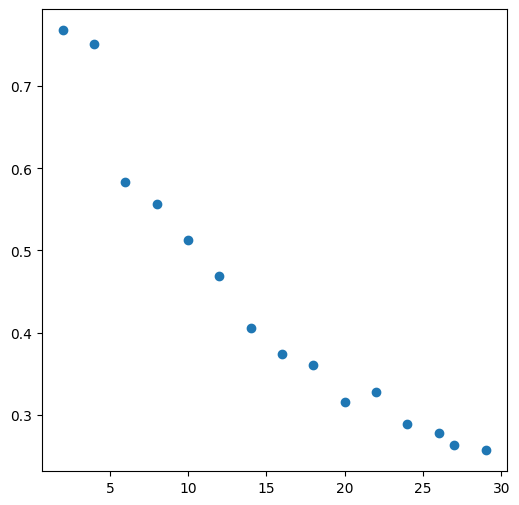

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)



### Purity Score/No Breakpoint

In [ ]:
!pip install permetrics

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
253,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
254,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


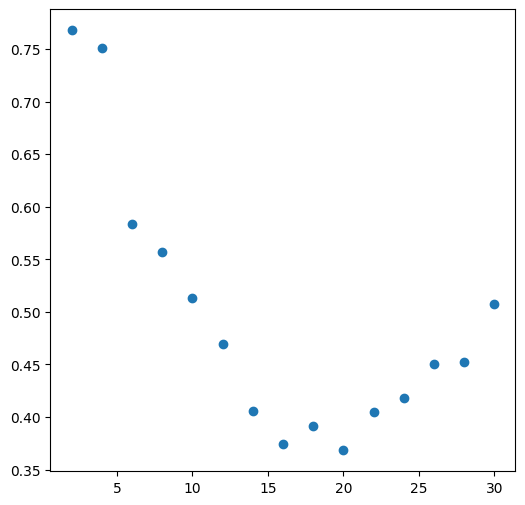

In [25]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.purity_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Purity Score/One Breakpoint

Optimal breakpoint 1: 14.222222222222221


/tmp/ipython-input-1430848010.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


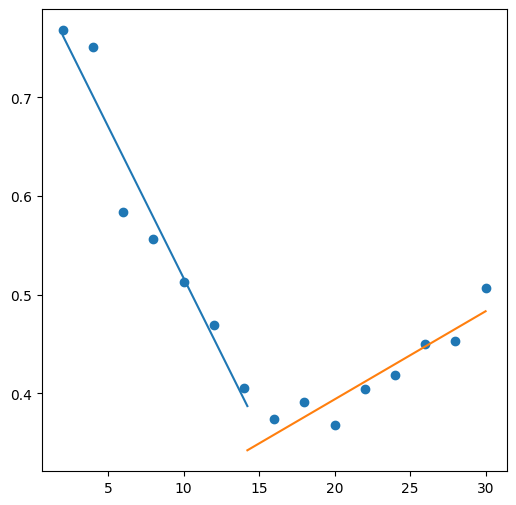

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Entropy Score/No Breakpoint

,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
253,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
254,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


/tmp/ipython-input-54321114.py:40: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-54321114.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


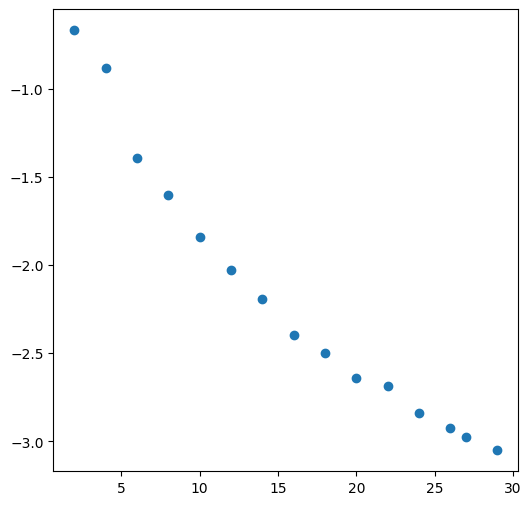

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)



In [ ]:
!pip install permetrics

### Entropy Score/No Breakpoint

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
253,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
254,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


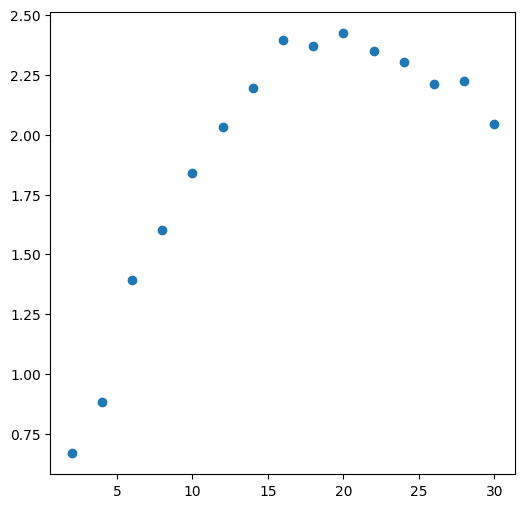

In [28]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.entropy_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Entropy Score/One Breakpoint

Optimal breakpoint 1: 10.000000005668202


/tmp/ipython-input-2898114523.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


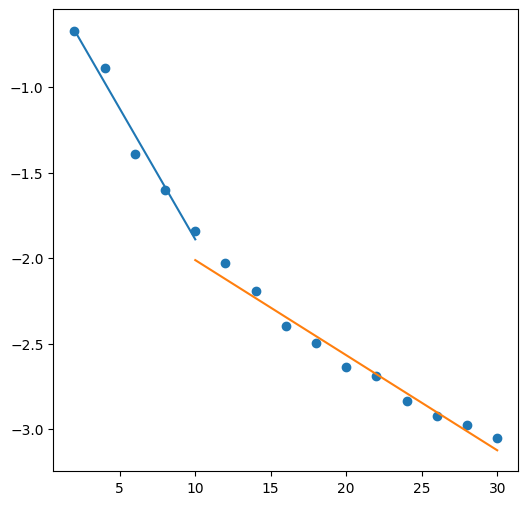

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])

